# Decision Tree Baseline

First, import required packages

In [1]:
# import required packages and methods
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Then, load training data and check the data types. `has_gender` column is removed because it's not important at all, and `type_2` is removed because it may reveal `type_1` information. 

In [2]:
# load training dataset
poke_train = pd.read_csv("./data/3-split_data.train.csv")
poke_train = poke_train.drop(columns=['has_gender'])
poke_train = poke_train.drop(columns=['type_2'])

# check data
poke_train.dtypes

generation                        float64
status                             object
type_number                       float64
type_1                             object
height_m                          float64
weight_kg                         float64
abilities_number                  float64
total_points                      float64
hp                                float64
attack                            float64
defense                           float64
sp_attack                         float64
sp_defense                        float64
speed                             float64
catch_rate                        float64
base_friendship                   float64
base_experience                   float64
maximum_experience                float64
egg_type_number                   float64
proportion_male                   float64
egg_cycles                        float64
damage_from_normal                float64
damage_from_fire                  float64
damage_from_water                 

Transform features to acceptable data types for sklearn decision trees

In [3]:
# create the column transformer
ct = ColumnTransformer([
    ('onehotstatus',
        OneHotEncoder(),
        make_column_selector(pattern='status'))],
    remainder='passthrough',
    verbose_feature_names_out=False)

# transform the data and create training data
X_train = ct.fit_transform(poke_train.drop(columns=['type_1']))
y_train = poke_train['type_1']

Generate the full decision tree

In [4]:
# create decision tree
clf_full = tree.DecisionTreeClassifier(
    criterion="gini",    # loss function
    min_samples_leaf=1,  # can have down to one observation per terminal node
    max_features=None,   # = n_features
    # remove all randomization e.g., due to two splits having the same decrease in loss
    random_state=2023
)

# fit to training data to get a full tree
clf_full.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2023)

Plotting the decision tree to check how it looks like

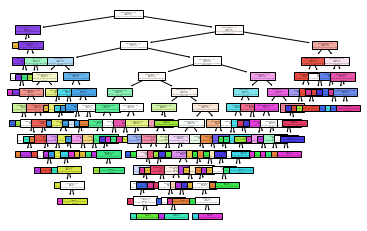

In [5]:
# plot the full decision tree
tree.plot_tree(clf_full, 
               filled=True, 
               feature_names=ct.get_feature_names_out())
plt.show()

### Cost Complexity Pruning

First, we plot the cost complexity pruning path on the full data. 

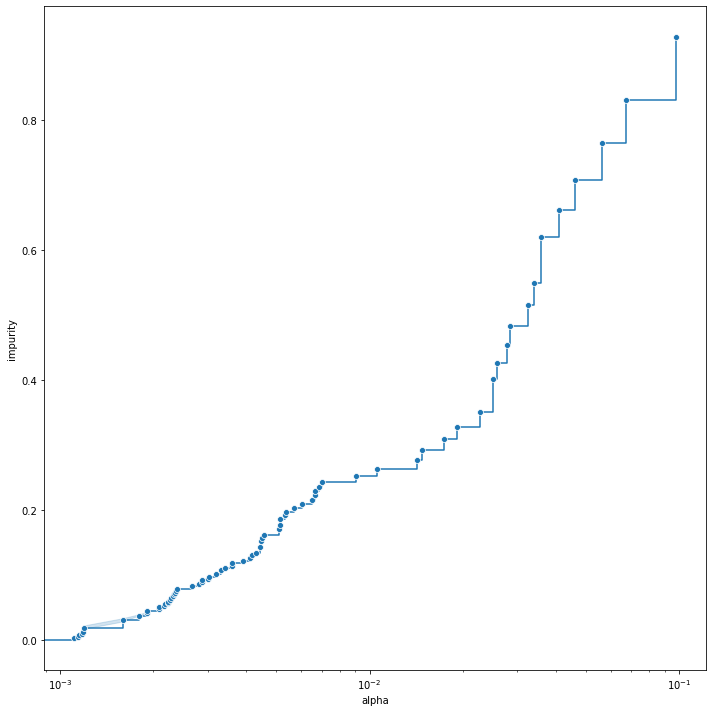

In [6]:
ccp_path = clf_full.cost_complexity_pruning_path(X_train, y_train)

plt.rcParams['figure.figsize'] = [10, 10]
sns.lineplot(
    data={"alpha": ccp_path.ccp_alphas,
          "impurity": ccp_path.impurities},
    x="alpha",
    y="impurity",
    marker="o",
    drawstyle="steps-post"
)
plt.xscale("log")
plt.tight_layout()

Proceed with crossvalidation to choose $\alpha$

In [7]:
# crossvalidation folds
n_folds = 5
cv = StratifiedKFold(
    n_splits=n_folds,  # number of folds
    shuffle=True,  # protects against data being ordered, e.g., all successes first
    random_state=2023
)

cv_loss = []
for (train_id, test_id) in cv.split(X_train, y_train):
    # foldwise training and test data
    X_train_i = X_train[train_id, :]
    y_train_i = y_train[train_id]
    X_test_i = X_train[test_id, :]
    y_test_i = y_train[test_id]

    # cost complexity pruning
    # first grow tree
    clf = tree.DecisionTreeClassifier(
        criterion="gini",  # loss function
        min_samples_leaf=1,  # can have down to one observation per terminal node
        max_features=None,  # = n_features
        # remove all randomization e.g., due to two splits having the same decrease in loss
        random_state=2023
    )
    # next calculate all alphas
    path = clf.cost_complexity_pruning_path(X_train_i, y_train_i)

    # calculate the missclassification error for each alpha
    loss = []
    for alpha in path.ccp_alphas:
        # fit the given tree
        clf_alpha = tree.DecisionTreeClassifier(
            criterion="gini",
            min_samples_leaf=1,
            max_features=None,
            random_state=2023,
            ccp_alpha=alpha  # cost complexity pruning parameter
        )
        # calculate the test error
        clf_alpha.fit(X_train_i, y_train_i)
        loss.append(1.0 - clf_alpha.score(X_test_i, y_test_i))
        
    cv_loss.append({
        "alpha": path.ccp_alphas,
        "loss": np.array(loss)
    })

Plot loss vs alpha for all folds

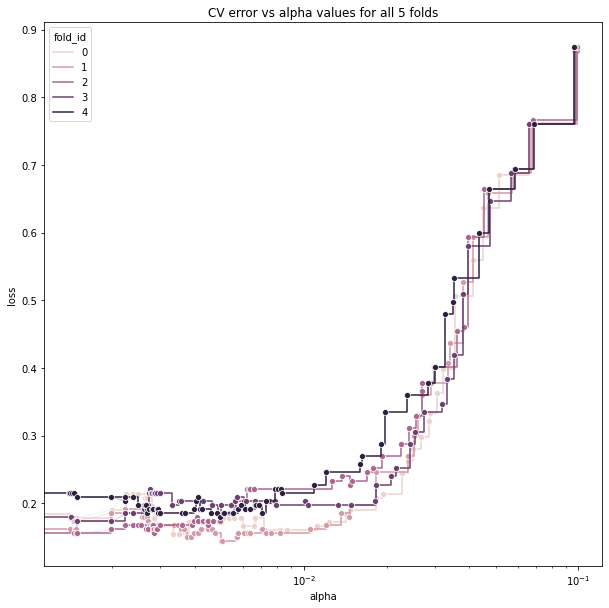

In [8]:
# loss vs alpha for each fold
plt_data = pd.concat([pd.DataFrame(cv_loss[i]).assign(fold_id=i) for i in np.arange(n_folds)])
sns.lineplot(
    data=plt_data,
    x="alpha",
    y="loss",
    hue="fold_id",    
    marker="o",
    drawstyle="steps-post"
)
plt.title("CV error vs alpha values for all 5 folds")
plt.xscale("log")

The average CV error as a function of $\alpha$ is calculated and plotted below.

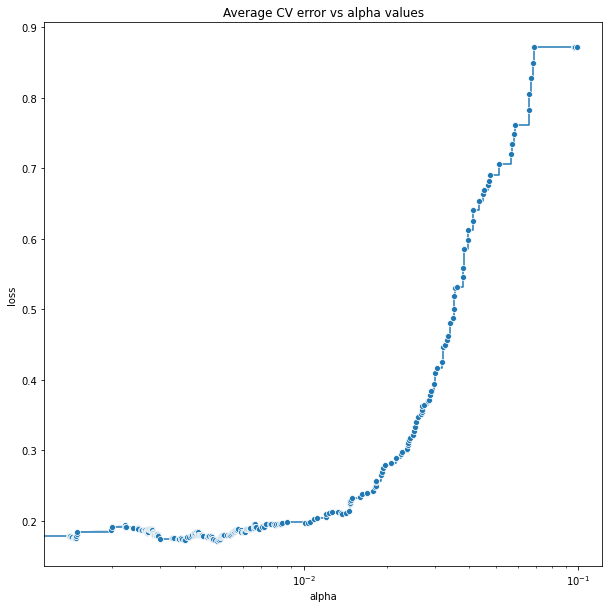

In [9]:
def step_fun(x, x_step, y_step):
    """
    Step function.

    Args:
        x: Vector of values at which to evaluate the step function.
        x_step: Vector of step x-values sorted in increasing order.
        y_step: Vector of step y-values.

    Returns:
        Vector of the same length as `x`, where each element is the value of `y_step` corresponding to the
            larges value of `x_step` which is less than or equal to `x`.
    """
    y = np.empty_like(x)
    ids = x < x_step[-1]
    y[ids] = y_step[np.searchsorted(x_step, x[ids], side="right")]
    y[~ids] = y_step[-1]
    return y


# full sequence of alphas
alpha_seq = np.sort(np.concatenate(
    [cv_loss[i]["alpha"] for i in np.arange(n_folds)]))

# corresponding cv error
loss_seq = [step_fun(alpha_seq,
          x_step=cv_loss[i]["alpha"],
          y_step=cv_loss[i]["loss"])
 for i in np.arange(n_folds)]
loss_seq = np.stack(loss_seq, axis=-1)
loss_seq = np.mean(loss_seq, axis=1)

sns.lineplot(
    data={"alpha": alpha_seq, "loss": loss_seq},
    x="alpha",
    y="loss",
    marker="o",
    drawstyle="steps-post"
)
plt.title("Average CV error vs alpha values")
plt.xscale("log")

0.00481315396113602


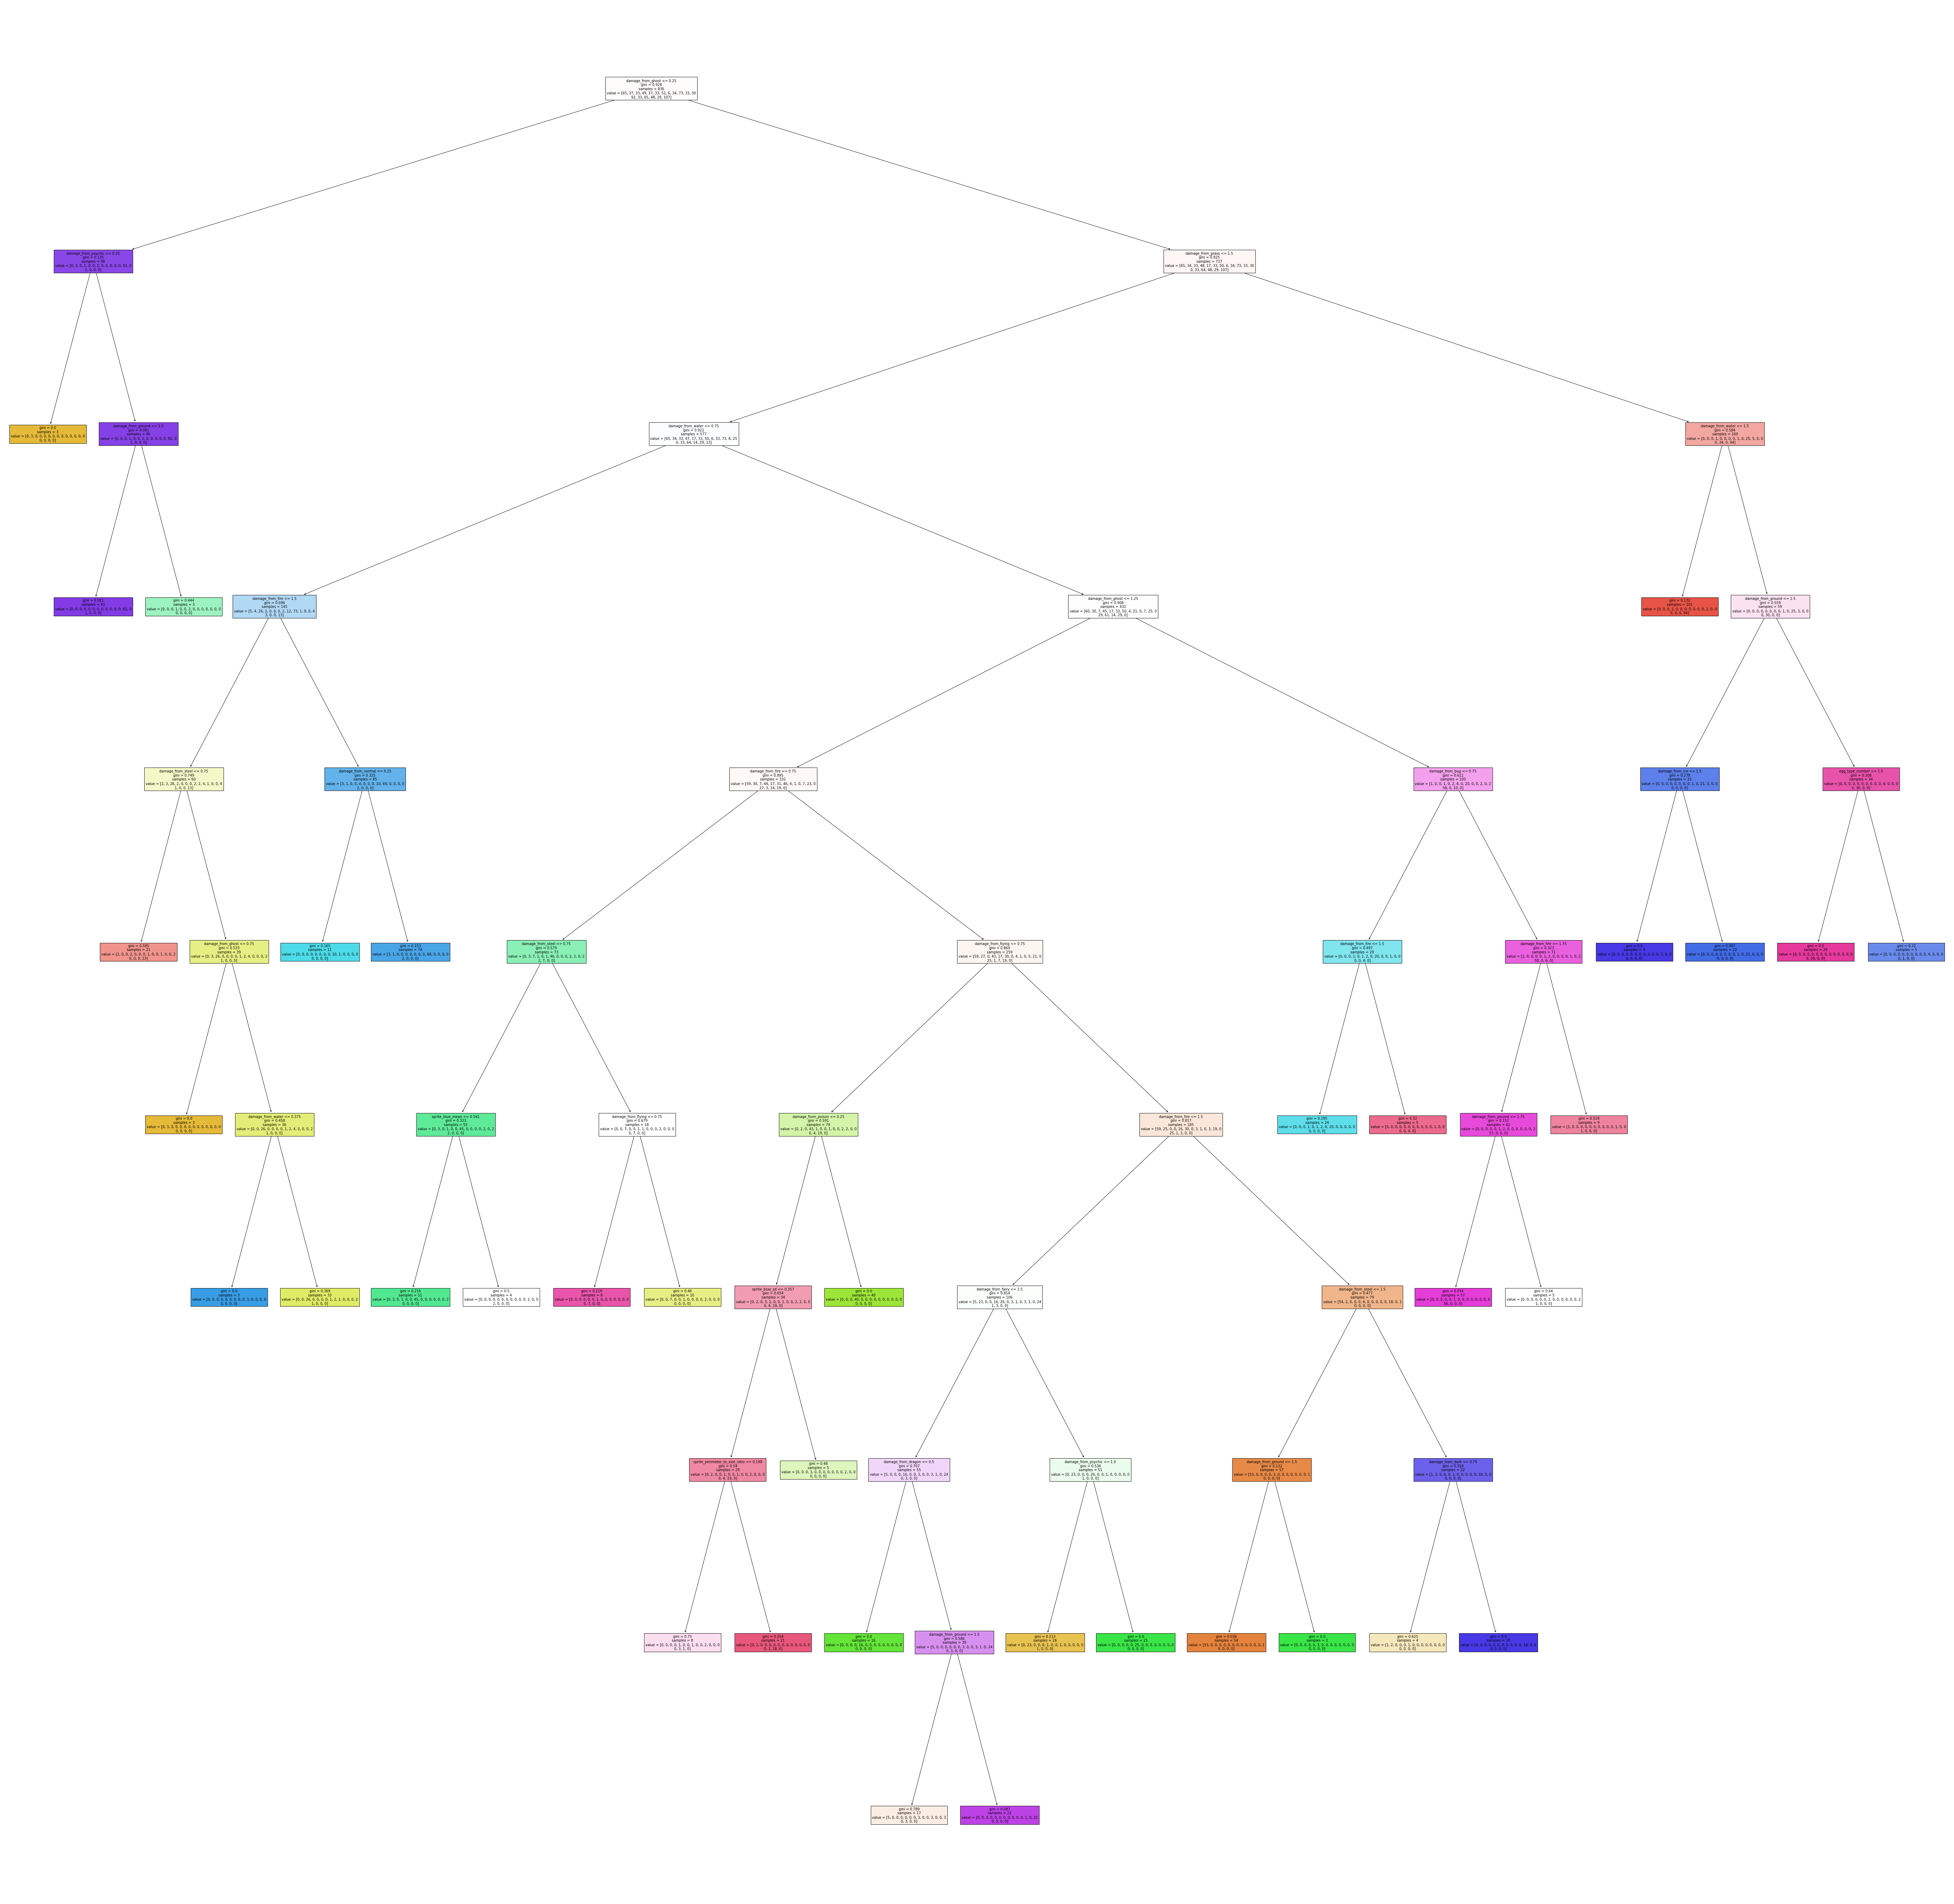

In [10]:
alpha_cv = alpha_seq[np.argmin(loss_seq)]  # selected value of alpha
print(alpha_cv)

clf_pruned = tree.DecisionTreeClassifier(
    criterion="gini",
    min_samples_leaf=1,
    max_features=None,
    random_state=2023,
    ccp_alpha=alpha_cv
)

clf_pruned.fit(X_train, y_train)
plt.rcParams['figure.figsize'] = [100, 100]
# plot the baseline decision tree
tree.plot_tree(clf_pruned,
               filled=True,
               feature_names=ct.get_feature_names_out())
plt.show()

Here we have an alpha of 0.00481315396113602 and 36 leaf nodes. Consider we have 18 classes, this tree is not too complex. To see the tree more clearly, one can download the picture and zoom in to see all the different nodes. 

### Testing the tree on test set

In [11]:
poke_test = pd.read_csv("./data/3-split_data.test.csv")
poke_test = poke_test.drop(columns=['has_gender'])
poke_test = poke_test.drop(columns=['type_2'])

X_test = ct.fit_transform(poke_test.drop(columns=['type_1']))
y_test = poke_test['type_1']

print(clf_pruned.score(X_test, y_test))

0.7942583732057417


So the decision tree is able to predict 79.4% correct in the test set, a good baseline to start with and compare more complex models with it as the project progress

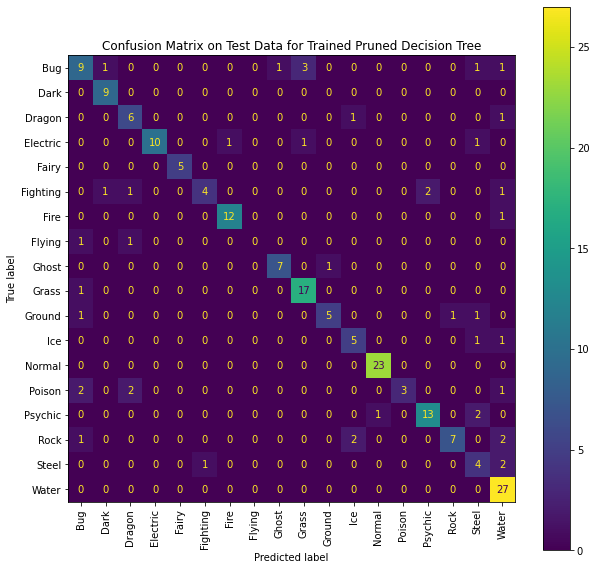

In [13]:
predictions = clf_pruned.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf_pruned.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_pruned.classes_)

plt.rcParams['figure.figsize'] = [10, 10]
display.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix on Test Data for Trained Pruned Decision Tree")
plt.show()